In [ ]:
from omegaconf import OmegaConf

conf = OmegaConf.load('coli.yaml')
conf.log_dir = conf.log_dir + f'd{conf.model.feature_dim}/'

In [ ]:
from dataset import Dataset_coli
batch_size = conf.train.batch_size
train_dataset = Dataset_coli(conf)
train_loader = train_dataset.getLoader(batch_size, shuffle=True)

In [ ]:
from model import EvolutionDynamicsModel

L = conf.coli.loci
input_channels = 1
feature_dim = conf.model.feature_dim
num_heads = conf.model.num_heads
num_layers = conf.model.num_layers
codebook_size = conf.model.K
pos_encoding_type = conf.model.pos_encoding_type
use_rotation = conf.model.use_rotation
code_init = conf.model.code_init
model = EvolutionDynamicsModel(feature_dim, L, num_heads, num_layers, pos_encoding_type=pos_encoding_type, codebook_size=codebook_size, use_rotation=use_rotation, code_init=code_init).to(conf.device)

# Pretraining

In [ ]:
import os
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
import warnings; warnings.filterwarnings("ignore")

optimizer = optim.Adam(model.parameters(), lr=conf.train.lr)
scheduler = ExponentialLR(optimizer, conf.train.lr_decay)
criterion = torch.nn.MSELoss()

try:
    model.load_state_dict(torch.load(conf.log_dir + f'checkpoints/pretrain_{conf.train.max_epoch}.pth', map_location=conf.device))
except:
    os.makedirs(conf.log_dir + 'checkpoints/', exist_ok=True)
    loss_ema_list = []
    for epoch in range(conf.train.max_epoch):
        model.train()
        loss_ema = None
        for i, x in enumerate(train_loader):
            # x: (batch_size, T, L)
            x = x.float().to(conf.device)
            
            optimizer.zero_grad()
            x_hat, z_e_x, z_q_x, indices = model(x, vq=False)
            
            # Reconstruction loss
            loss_recons = criterion(x_hat, x)
            
            loss = loss_recons
            loss_ema = loss_recons.item() if loss_ema is None else 0.95*loss_ema + 0.05*loss.item()
            
            loss.backward()
            optimizer.step()
            if i % 100 == 0:
                print(f'Epoch {epoch:03d}, batch {i:03d} | recons: {loss_recons.item():.5f}')
        scheduler.step()
        loss_ema_list.append(loss_ema)
    
    torch.save(model.state_dict(), conf.log_dir + f'checkpoints/pretrain_{epoch+1}.pth')

    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(loss_ema_list)
    plt.show()

# Testing

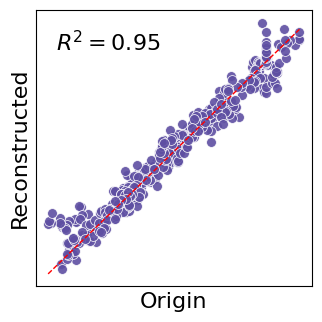

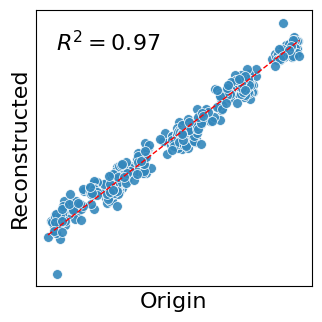

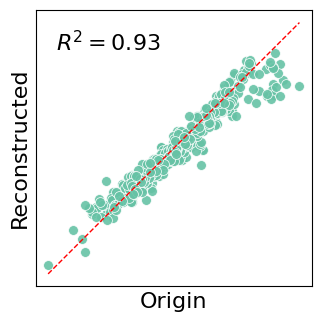

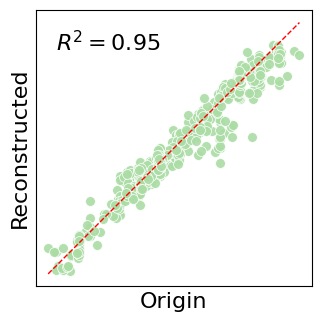

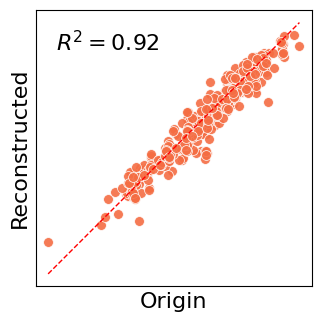

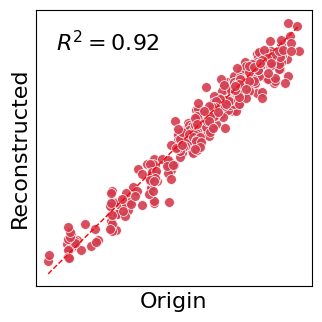

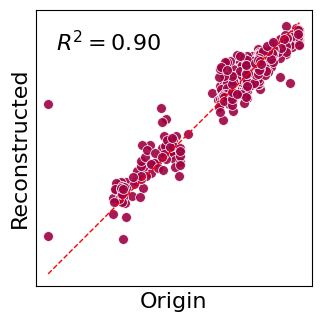

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'xtick.labelsize': 16})
plt.rcParams.update({'ytick.labelsize': 16})
plt.rcParams.update({'legend.fontsize': 16})

original_traj = Dataset_coli(conf, test=True).test_data # (N, T, L), (N, T, L), (N, T, L, nstates) 
original_traj = torch.tensor(original_traj).float().to(conf.device)
x_hat, z_e_x, z_q_x, indices = model(original_traj, vq=False)
cmap = sns.color_palette("Spectral", as_cmap=True, n_colors=10)
for i in range(7):
    plt.figure(figsize=(3.5, 3.5))
    ax = plt.subplot(111)
    r2 = r2_score(original_traj[:, :, i].detach().cpu().numpy(), x_hat[:, :, i].detach().cpu().numpy())
    # ax.scatter(original_traj[:, :, i].detach().cpu().numpy(), x_hat[:, :, i].detach().cpu().numpy())
    ax.plot([original_traj[:, :, i].min().item(), original_traj[:, :, i].max().item()], [original_traj[:, :, i].min().item(), original_traj[:, :, i].max().item()], 'r--', lw=1)
    ax.text(0.075, 0.85, rf'$R^2={r2:.2f}$', transform=ax.transAxes)
    ii = 10 - i
    sns.scatterplot(x=original_traj[:, :, i].detach().cpu().numpy().reshape(-1), y=x_hat[:, :, i].detach().cpu().numpy().reshape(-1), s=50, alpha=0.9, color=cmap(ii/10 if i < 4 else ii/10-0.4))
    plt.xlabel('Origin')
    plt.ylabel('Reconstructed')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.savefig(f'figs/fig6/drug_{i}.pdf', dpi=300)

# Vis

In [ ]:
# original_traj = original_traj.detach().cpu().numpy()
# x_hat = x_hat.detach().cpu().numpy()

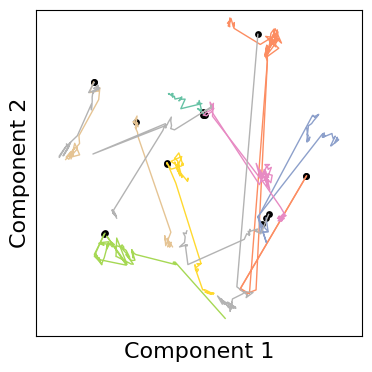

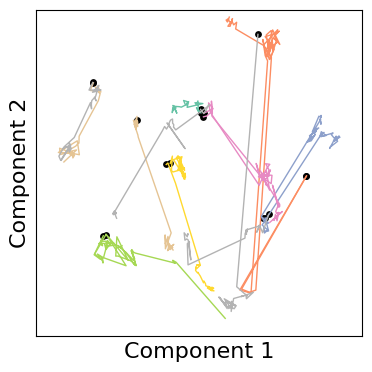

In [7]:
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
# plt.rcParams.update({'font.size': 16})
# plt.rcParams.update({'xtick.labelsize': 16})
# plt.rcParams.update({'ytick.labelsize': 16})
# plt.rcParams.update({'legend.fontsize': 16})


# pca = TSNE(n_components=2)
# N, T, L = original_traj.shape
# traj_concat = np.concatenate([original_traj.reshape(N*T, L), x_hat.reshape(N*T, L)], axis=0)
# traj_tsne = pca.fit_transform(traj_concat)
# original_traj_tsne = traj_tsne[:N*T].reshape(N, T, 2)
# x_hat_tsne = traj_tsne[N*T:].reshape(N, T, 2)

# plt.figure(figsize=(4, 4))
# cmap = plt.get_cmap('Set2', len(np.arange(1, N+1)))
# for i in range(N):
#     plt.scatter(original_traj_tsne[i, 0, 0], original_traj_tsne[i, 0, 1], color='black', s=15)
#     plt.plot(original_traj_tsne[i, :, 0], original_traj_tsne[i, :, 1], color=cmap(i+1), linewidth=1)
# plt.xlabel('Component 1')
# plt.ylabel('Component 2')
# plt.xlim(-50, 50)
# plt.ylim(-40, 40)
# plt.xticks([])
# plt.yticks([])
# plt.tight_layout()
# plt.savefig('figs/fig6/traj_gt.pdf', dpi=300)

# plt.figure(figsize=(4, 4))
# cmap = plt.get_cmap('Set2', len(np.arange(1, N+1)))
# for i in range(N):
#     plt.scatter(x_hat_tsne[i, 0, 0], x_hat_tsne[i, 0, 1], color='black', s=15)
#     plt.plot(x_hat_tsne[i, :, 0], x_hat_tsne[i, :, 1], color=cmap(i+1), linewidth=1)
# plt.xlabel('Component 1')
# plt.ylabel('Component 2')
# plt.xlim(-50, 50)
# plt.ylim(-40, 40)
# plt.xticks([])
# plt.yticks([])
# plt.tight_layout()
# plt.savefig('figs/fig6/traj_hat.pdf', dpi=300)

In [ ]:
# from sklearn.decomposition import PCA

# dim = z_e_x.shape[-1]
# latent_embedding = z_e_x.reshape(-1, z_e_x.shape[-1]).detach().cpu().numpy()
# # (N*T, D)
# pca = PCA(n_components=latent_embedding.shape[-1])
# pca.fit(latent_embedding)
# var = pca.explained_variance_ratio_
# plt.figure(figsize=(6, 4))
# sns.barplot(x=np.arange(1, dim+1), y=var, palette=sns.light_palette("salmon", reverse=True, n_colors=dim))
# plt.xlabel('Principal Component')
# plt.ylabel('Explained Variance')
# plt.xticks(np.arange(0, dim, 4)+1)
# plt.ylim(0, 0.16)
# plt.yticks(np.arange(0, 0.16, 0.05))
# plt.gca().yaxis.set_major_formatter(lambda x, pos: f'{x*100:.0f}%')
# plt.twinx()
# sns.lineplot(x=np.arange(dim), y=np.cumsum(var), marker='o', color='black', label='Cumulative')
# plt.legend(loc='upper left', frameon=False)
# plt.ylim(0, 1.15)
# plt.yticks([])
# plt.tight_layout()
# plt.savefig('figs/fig6/coli_var.pdf', dpi=300)

# Encoding Dim

In [ ]:
# import pandas as pd
# from sklearn.metrics import r2_score

# df = pd.DataFrame(columns=['feature_dim', 'nmse'])
# for idx, feature_dim in enumerate([8, 16, 24, 32, 40, 48, 56, 64]):
#     conf = OmegaConf.load('coli.yaml')
#     conf.log_dir = conf.log_dir + f'd{feature_dim}/'

#     L = conf.coli.loci
#     input_channels = 1
#     num_heads = conf.model.num_heads
#     num_layers = conf.model.num_layers
#     codebook_size = conf.model.K
#     pos_encoding_type = conf.model.pos_encoding_type
#     use_rotation = conf.model.use_rotation
#     code_init = conf.model.code_init
#     model = EvolutionDynamicsModel(feature_dim, L, num_heads, num_layers, pos_encoding_type=pos_encoding_type, codebook_size=codebook_size, use_rotation=use_rotation, code_init=code_init).to(conf.device)
#     model.load_state_dict(torch.load(conf.log_dir + f'checkpoints/pretrain_{conf.train.max_epoch}.pth', map_location=conf.device))

#     original_traj = Dataset_coli(conf, test=True).test_data # (N, T, L), (N, T, L), (N, T, L, nstates) 
#     original_traj = torch.tensor(original_traj).float().to(conf.device)
#     x_hat, z_e_x, z_q_x, indices = model(original_traj, vq=False)
    
#     for traj in zip(original_traj, x_hat):
#         # r2 = r2_score(traj[0].detach().cpu().numpy(), traj[1].detach().cpu().numpy())
#         nmse = torch.mean((traj[0] - traj[1])**2) / torch.mean(traj[0]**2)
#         df = df._append({'feature_dim': feature_dim, 'nmse': nmse.item()}, ignore_index=True)


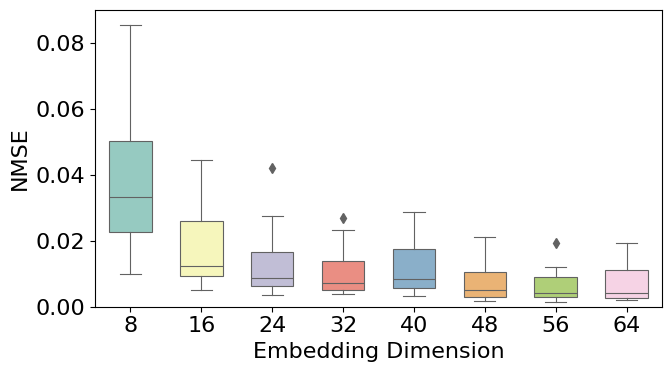

In [47]:
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size': 16})
# plt.rcParams.update({'xtick.labelsize': 16})
# plt.rcParams.update({'ytick.labelsize': 16})
# plt.rcParams.update({'legend.fontsize': 16})

# plt.figure(figsize=(7, 4))
# sns.boxplot(data=df, x='feature_dim', y='nmse',
#                     palette='Set3',
#                     width=0.6,
#                     linewidth=0.8,
#                     )
# plt.xlabel('Embedding Dimension')
# plt.ylabel('NMSE')
# plt.xticks(range(8), [8, 16, 24, 32, 40, 48, 56, 64])
# plt.ylim(0, 0.09)
# plt.yticks(np.arange(0, 0.10, 0.02))
# plt.tight_layout()
# plt.savefig('figs/fig6/coli_dim.pdf', dpi=300)

# Distilling

In [ ]:
from model import GenotypeEncoder

L = conf.coli.loci
feature_dim = conf.model.feature_dim
model2 = GenotypeEncoder(L, feature_dim).to(conf.device)

optimizer = optim.Adam(model2.parameters(), lr=1e-3)
scheduler = ExponentialLR(optimizer, conf.train.lr_decay)
criterion = torch.nn.MSELoss()

try:
    model2.load_state_dict(torch.load(conf.log_dir + f'checkpoints/distill_{1000}.pth', map_location=conf.device))
except:
    loss_ema_list = []
    for epoch in range(1000):
        model2.train()
        loss_ema = None
        for i, x in enumerate(train_loader):
            # x: (batch_size, T, L, b)
            x = x.float().to(conf.device)
            
            optimizer.zero_grad()
            z = model2(x)
            
            with torch.no_grad():
                z_e_x, z_q_x = model.encode(x)
            
            # Reconstruction loss
            loss_recons = criterion(z, z_e_x)        
            loss = loss_recons
            loss_ema = loss_recons.item() if loss_ema is None else 0.95*loss_ema + 0.05*loss.item()
            
            loss.backward()
            optimizer.step()
            if i % 100 == 0:
                print(f'Epoch {epoch:03d}, batch {i:03d} | recons: {loss_recons.item():.5f}')
        scheduler.step()
        loss_ema_list.append(loss_ema)
    
    os.makedirs(conf.log_dir + 'checkpoints/', exist_ok=True)
    torch.save(model2.state_dict(), conf.log_dir + f'checkpoints/distill_{epoch+1}.pth')

    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(loss_ema_list)
    plt.show()